In [1]:
!pip install --quiet git+https://github.com/EddyEdzwan/StopFAIke.git

     |████████████████████████████████| 141 kB 21.6 MB/s 
     |████████████████████████████████| 73 kB 1.7 MB/s 
     |████████████████████████████████| 185 kB 47.8 MB/s 
     |████████████████████████████████| 14.6 MB 85 kB/s 
     |████████████████████████████████| 87 kB 5.3 MB/s 
     |████████████████████████████████| 1.5 MB 22.1 MB/s 
     |████████████████████████████████| 747 kB 50.3 MB/s 
     |████████████████████████████████| 743 kB 39.9 MB/s 
     |████████████████████████████████| 41 kB 569 kB/s 
     |████████████████████████████████| 68 kB 5.5 MB/s 
     |████████████████████████████████| 1.3 MB 53.3 MB/s 
     |████████████████████████████████| 118 kB 56.3 MB/s 
     |████████████████████████████████| 294 kB 54.6 MB/s 
     |████████████████████████████████| 142 kB 47.6 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 1.1 MB 40.0 MB/s 
     |████████████████████████████████| 146 kB 50.5 MB/s 
     |███████████████████

In [2]:
  import nltk
  nltk.download('punkt')
  nltk.download('stopwords')
  nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
# from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import json
import numpy as np
# import nltk
# import string
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
from StopFAIke import data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Loading the Dataset

In [4]:
#Reading the csv from Google Cloud Bucket
fake_df = pd.read_csv('https://storage.googleapis.com/stopfaike_eddy/data/Fake.csv')
real_df = pd.read_csv('https://storage.googleapis.com/stopfaike_eddy/data/True.csv')

In [5]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
fake_df['target'] = 1
real_df['target'] = 0

In [8]:
df = pd.concat([fake_df, real_df], axis=0)

df.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [9]:
assert (fake_df.shape[0]+real_df.shape[0]) == df.shape[0]

# Cleaning and Preparing the Dataset

In [10]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

In [11]:
#Apply the standard clean function on text column for preprocessing
df['title_preprocessed_lemmatized'] = df['title'].apply(data.clean)
df['text_preprocessed_lemmatized'] = df['text'].apply(data.clean)
df['title_preprocessed_joined'] = df['title_preprocessed_lemmatized']. \
                                                apply(lambda x: ' '.join(word for word in x))
df['text_preprocessed_joined'] = df['text_preprocessed_lemmatized']. \
                                                apply(lambda x: ' '.join(word for word in x))

df.head()

,title,text,subject,date,target,title_preprocessed_lemmatized,text_preprocessed_lemmatized,title_preprocessed_joined,text_preprocessed_joined
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,"[donald, trump, sends, embarrassing, new, year...","[donald, trump, wish, american, happy, new, ye...",donald trump sends embarrassing new year eve m...,donald trump wish american happy new year leav...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,"[drunk, bragging, trump, staffer, started, rus...","[house, intelligence, committee, chairman, dev...",drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,"[sheriff, david, clarke, becomes, internet, jo...","[friday, revealed, former, milwaukee, sheriff,...",sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,"[trump, obsessed, even, obama, name, coded, we...","[christmas, day, donald, trump, announced, wou...",trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,"[pope, francis, called, donald, trump, christm...","[pope, francis, used, annual, christmas, day, ...",pope francis called donald trump christmas speech,pope francis used annual christmas day message...


In [12]:
y = df.pop('target')
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
X_train.shape

(31428, 8)

In [14]:
y.value_counts()

1    23481
0    21417
Name: target, dtype: int64

In [15]:
y_train.value_counts()

1    16389
0    15039
Name: target, dtype: int64

In [38]:
y_test.value_counts()

1    7092
0    6378
Name: target, dtype: int64

# Performing the LDA

In [16]:
#Training a vectorizer on the training dataset and transforming both train and test sets into vectors
tfidf_vectorizer = TfidfVectorizer()

train_text = tfidf_vectorizer.fit_transform(X_train['text_preprocessed_joined'])

test_text = tfidf_vectorizer.transform(X_test['text_preprocessed_joined'])

In [17]:
#Instantiating a LDA model (of five topics) and training on the training dataset
lda_model = LatentDirichletAllocation(n_components=5, n_jobs=-1)

lda_model.fit(train_text)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [18]:
#Defining a function to print the top 10 words in the two topics

def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])
        

print_topics(lda_model, tfidf_vectorizer)

Topic 0:
[('tax', 192.7893769557913), ('senate', 171.2041362064459), ('republican', 143.89633574507863), ('house', 136.8732796810783), ('bill', 118.99246784265301), ('said', 110.5322288962092), ('committee', 95.54673304277038), ('washington', 86.36930354198714), ('obamacare', 85.43894939838627), ('legislation', 82.68397505253166)]
Topic 1:
[('zuma', 12.921258426587851), ('babis', 12.714440649163839), ('anc', 10.130878217643648), ('nasralla', 9.285093256214422), ('ramaphosa', 9.020203192454398), ('ratcliffe', 7.53910841678382), ('zaghari', 6.514890330992373), ('dlamini', 6.492400843327491), ('hernandez', 6.0596128532484705), ('sirleaf', 4.548973206976468)]
Topic 2:
[('boiler', 50.650470860741365), ('acr', 45.746390046394964), ('pm', 32.09390601725525), ('room', 29.121442347875316), ('radio', 23.59902921720394), ('broadcast', 22.2296961580391), ('join', 21.351892917967362), ('episode', 19.149396963835272), ('alternate', 16.82040083439873), ('tune', 16.74231609030773)]
Topic 3:
[('trump',

In [ ]:
lda_model.components_.argsort()

array([[62628, 40524, 34987, ..., 35291, 11506, 70060],
       [35761, 26626, 31676, ..., 58247, 64923, 76668]])

In [19]:
lda_model.transform(test_text)

array([[0.01768716, 0.01757129, 0.0176321 , 0.92886555, 0.0182439 ],
       [0.01246697, 0.01213702, 0.01213959, 0.38480958, 0.57844684],
       [0.09718894, 0.01989481, 0.02102951, 0.63221715, 0.22966958],
       ...,
       [0.01918692, 0.01902621, 0.01904872, 0.01943104, 0.92330711],
       [0.016679  , 0.01651272, 0.01650796, 0.93320311, 0.01709721],
       [0.022845  , 0.02247613, 0.02253883, 0.90928386, 0.02285617]])

In [20]:
preds = []

for item in lda_model.transform(test_text):
  if item[0] > 0.5:
    preds.append(0)
  elif item[1] > 0.5:
   preds.append(1)
  elif item[2] > 0.5:
    preds.append(2)
  elif item[3] > 0.5:
    preds.append(3)
  else:
    preds.append(4)

len(preds)

13470

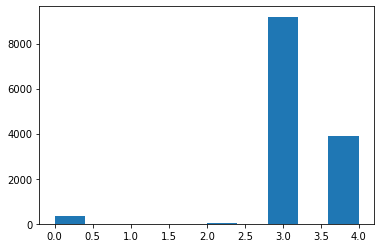

In [21]:
plt.hist(preds);

In [22]:
#Instantiating a LDA model (of ten topics) and training on the training dataset
lda_model = LatentDirichletAllocation(n_components=10, n_jobs=-1)

lda_model.fit(train_text)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [37]:
lda_model.components_

array([[0.10000002, 0.10000003, 0.10000003, ..., 0.10000001, 0.10000004,
        0.10000002],
       [0.10000003, 0.10000003, 0.18079095, ..., 0.10000001, 0.10000004,
        0.10000002],
       [0.10035979, 0.10061161, 0.100394  , ..., 0.1       , 0.21888061,
        0.17168015],
       ...,
       [0.10106966, 0.10000002, 0.10000002, ..., 0.10006641, 0.10000003,
        0.10000002],
       [0.10000346, 0.10000003, 0.10000003, ..., 0.10000001, 0.10000004,
        0.10000002],
       [0.38102683, 0.32114437, 0.1       , ..., 0.1       , 0.10000001,
        0.1       ]])

In [34]:
#Defining a function to print the top 10 words in the two topics

def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])
        

print_topics(lda_model, tfidf_vectorizer)

Topic 0:
[('odinga', 18.127086709625083), ('kenyatta', 15.201115030381041), ('nasralla', 9.205793976154517), ('hernandez', 9.16075400039334), ('nairobi', 9.135437718499182), ('kenya', 8.505603338759723), ('yangon', 8.402278616497268), ('kenyan', 7.203346888587503), ('berlusconi', 6.605207763233644), ('crowder', 6.569845036679023)]
Topic 1:
[('www', 24.392144954105426), ('youtube', 20.346075623586522), ('http', 17.85619894914133), ('watch', 17.676284426169083), ('com', 16.219435905751734), ('shiva', 3.043619082764058), ('senwarren', 2.9037373677264937), ('markle', 2.7077387474681385), ('warsh', 2.5761256618767043), ('tawhidi', 2.5735174485769075)]
Topic 2:
[('said', 487.92037005336425), ('trump', 467.0429712626759), ('state', 286.25067650078904), ('president', 276.6965558738053), ('house', 262.8875744599816), ('korea', 232.72690316333689), ('would', 224.4981634773354), ('russia', 223.44643769284562), ('north', 222.84960350534263), ('reuters', 219.52544529433234)]
Topic 3:
[('trump', 110

In [31]:
preds = []

for item in lda_model.transform(test_text):
  for id, prob in enumerate(item):
    if prob == max(item):
      preds.append(id)
      break

len(preds)

13470

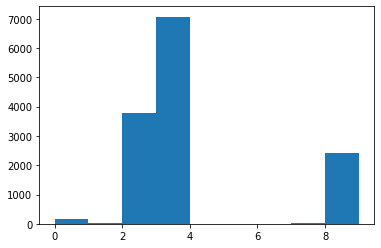

In [35]:
plt.hist(preds,bins=range(0,10));

In [39]:
preds_transformed = []

for pred in preds:
  if pred == 3:
    preds_transformed.append(1)
  else:
    preds_transformed.append(0)

len(preds_transformed)

13470

# Conclusion

In [40]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [41]:
print(f'The recall of the LDA model trained is {recall_score(y_test, preds_transformed)}')
print(f'The precision of the LDA model trained is {precision_score(y_test, preds_transformed)}')
print(f'The accuracy of the LDA model trained is {accuracy_score(y_test, preds_transformed)}')

The recall of the LDA model trained is 0.8403835307388607
The precision of the LDA model trained is 0.842998585572843
The accuracy of the LDA model trained is 0.8335560504825539


<text> It is alarming to find that the scores are so high from an unsupervised LDA model designed solely on topic modelling. This tells us that the data is someone skewed, with distinguishable topics being mentioned in fake articles, allowing for the model to know that these are fake. However, in real world application, this is not usually the case - two articles can be talking about the same topic but one is fake and the other is real. Therefore, we conclude to put aside the Bisaillon dataset for now while we build our model with new information.  </text>